# Backtesting on Synthetic Data (Using Ornstein-Uhlenbeck Process)
# Presented by: Posh Raj Dahal
# MSc. Data Science 
# Matriculation No: 23172495
---

In [2]:
import sys
import importlib
sys.path.append('../')

# %load_ext autoreload
# %autoreload 2

In [3]:
import pandas as pd
# import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from src.finance_ml.synthetic_backtesting import synthetic_backtesting as sb
from src.finance_ml.data_preparation.data_preparation import DataLoader

# Visualization
---

# Discrete Ornstein-Uhlenbeck Process

$$ P_{t+1} = (1-\varphi)E_0\left[P_{T}\right] +\varphi P_{t} + \sigma \varepsilon_{t}, $$
where:
- $T$ is the exit time;
- $P_t$ price at time $t$; 
- $E_0[P_{T}]$ the expected value of $P$ at instance $T$;
- $\varphi$ and $\sigma$ are parameters to estimate;
- $\varepsilon \sim \mathcal N(0,1)$ is a white-noise.

In [5]:
# This function can be used to understand the Ornstein-Uhlenbeck Process.

sb.visualization_ornstein_uhlenbeck()

interactive(children=(IntSlider(value=100, description='INITIAL_PRICE', min=100), IntSlider(value=105, descrip…

# Example
---

Suppose we have a stock with the following parameters for $P_0$ and we wish to forecast $E_0[P_{100}] = 110$. Assuming that $(P_t)_t$ can be modeled by a discrete OU process, suppose that $\varphi = 0.9$ and $\sigma = 0.5$.

In [6]:
initial_price = 100
forecast = 110
sigma = .5
phi = .9
MAXIMUM_HOLDING_PERIOD = 100 
NUM_SCENARIOS = 100
position = 0

Therefore, using the OU process, we simulate different stock price scenarios: 

In [7]:
paths = sb.generate_paths_ornstein_uhlenbeck(
    initial_price = initial_price,
    forecast = forecast,
    sigma = sigma,
    phi = phi,
    MAXIMUM_HOLDING_PERIOD = MAXIMUM_HOLDING_PERIOD,
    NUM_SCENARIOS = NUM_SCENARIOS
)
#Generates 100 scenarios of paths  for OU Process

The `paths` is a data frame where:
- each column is a possible path (scenario)	for the stock price;
- each row is a time step. 

In [8]:
paths.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,100.930868,100.828643,101.526901,100.989549,101.311425,100.703803,100.377673,99.959035,100.552696,100.846111,...,100.826238,101.309034,101.203545,101.084987,100.395282,100.513586,101.307481,100.942406,101.473309,100.660753
2,102.161625,101.344640,101.685376,101.949258,101.646472,101.201427,100.450545,101.811360,101.403991,101.871075,...,101.165336,102.351394,103.059721,102.327400,101.977168,101.443446,102.778522,101.256622,102.793306,101.441928
3,103.706978,102.129533,102.047926,103.393165,102.410635,102.105545,102.153513,102.735733,102.043726,102.808659,...,102.689422,102.612038,103.256320,103.413114,103.143035,102.583981,102.756027,102.597865,103.698938,101.999044
4,104.219203,103.118605,103.100651,103.758062,103.229720,102.479516,103.265344,103.413803,103.562843,104.316520,...,104.028703,102.585960,103.550787,103.834240,103.861677,103.163494,103.357427,103.589695,103.770381,102.854349


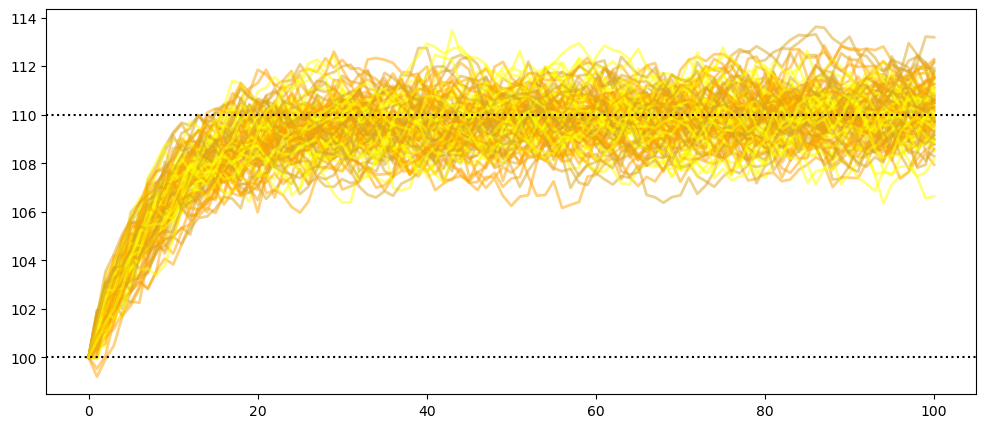

In [9]:
sb.plot_ornstein_uhlenbeck(generated_paths = paths, INITIAL_PRICE = initial_price, FORECAST = forecast, SIGMA = sigma)

Alternatively, given a time series $(P_t)_t$ and a forecast $E_0[P_T]$, we can estimate the generator parameters $\widehat\varphi$ and $\widehat\sigma$. Since we've created $(P_t)_t$ with `True` parameters $\varphi$ and $\sigma$, we can estimate the parameters using the `estimate_parameters_ornstein_uhlenbeck` function.

In [10]:
parameters = sb.estimate_parameters_ornstein_uhlenbeck(
    historical_prices = paths[0],
    position = position,
    forecast = forecast
)
pd.Series(parameters)

phi_hat      0.897320
sigma_hat    0.457088
dtype: float64

The `mesh_ornstein_uhlenbeck` function generates the horizontal bars for exiting the position:
 - `MAX_MESH` is the maximum distance between the avarage position price and a bar in sigmas.
 - `MESH_DIMENSION` is the amount of bars generated above or below, the combination of two such values is a trading rule.

In [11]:
MAX_MESH = 10
MESH_DIMENSION = 20
mesh = sb.mesh_ornstein_uhlenbeck(
    initial_price = initial_price,
    sigma = sigma,
    MAX_MESH=MAX_MESH,
    MESH_DIMENSION=MESH_DIMENSION)

lower_bound, upper_bound = [mesh[:,i] for i in range(2)]

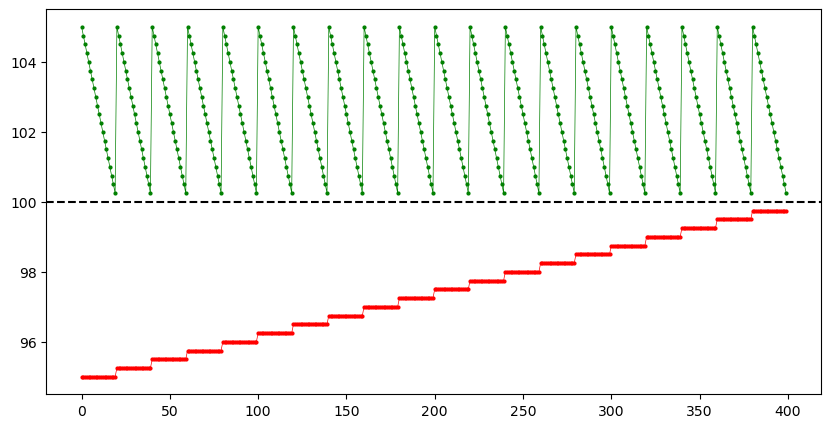

In [11]:
# A graph to ilustrate the trading rules generated. For each value of lower bar (red dots) there are MESH_DIMENSION green dots corresponding to upper bars.

fig, ax = plt.subplots(figsize=(10, 5))

key_args = {'marker': 'o',  'lw': 0.5, 'markersize': 2}

xs = range(upper_bound.shape[0])
ax.plot(xs, upper_bound, color='green',  **key_args)
ax.plot(xs, lower_bound, color='red', **key_args)
ax.axhline(initial_price, color='black', ls='--')

plt.show()

The function `simulate_one_box` simulates a pair of exit bars on the generates paths and returns the exit position on each scenario.

In [12]:
trading_rule = mesh[399]

simulated_box = sb.simulate_one_box(
    generated_paths = paths,
    trading_rule = trading_rule
)

pd.Series(simulated_box)

0     100.930868
1     100.828643
2     101.526901
3     100.989549
4     101.311425
         ...    
95    100.513586
96    101.307481
97    100.942406
98    101.473309
99    100.660753
Length: 100, dtype: float64

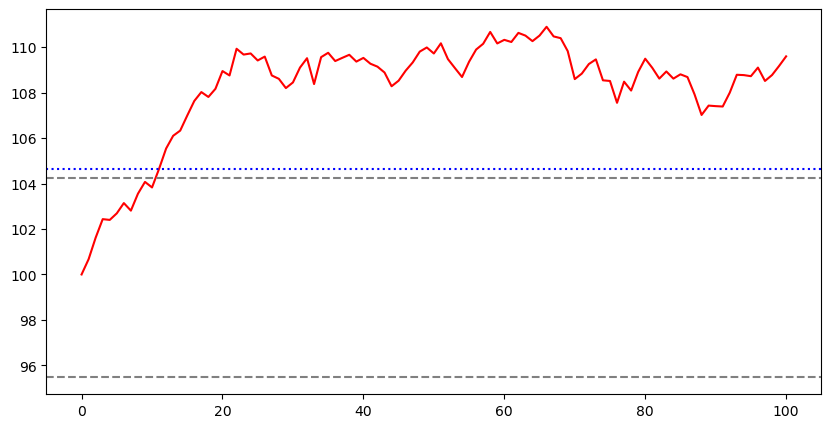

In [13]:
# A graph showing the simulate_one_box function. In red is a scenario, the dashed gray lines correspond to the trading rule tested, and the dotted blue line is the exit position.

scenario = 43
fig, ax = plt.subplots(figsize=(10, 5))

trading_rule = mesh[scenario]
lower, upper = trading_rule

simulated_box = sb.simulate_one_box(
    generated_paths = paths,
    trading_rule = trading_rule
)

ax.plot(paths[scenario].tolist(),color='red')
ax.axhline(lower, color='gray', ls='--')
ax.axhline(upper, color='gray', ls='--')
ax.axhline(simulated_box[scenario], color='blue', ls=':')

plt.show()

In what follows we examplify the function `optimal_trading_rule` using `Lopez's experiments (Chapter 13)`.\
In this implementation we opted to return `all data` in order to do some data analysis. We done that using the parameter `TEST` to pass `sigma` and `phi` values.

In [14]:
Lopez_exp_phi = pd.DataFrame(index=range(1, 26), 
        columns = ['Forecast', 'Half-Life (tau)'])
Half_life = [5, 10, 25, 50, 100]
Forecast = [0, 5, 10, -5, -10]

for i in range(5):
    for j in range(5):
        Lopez_exp_phi.iloc[5*(i)+(j)]=[Forecast[i], Half_life[j]]

In [15]:
Lopez_exp_phi['Phi'] = Lopez_exp_phi['Half-Life (tau)'].apply(sb.tau_to_phi)

In [16]:
#Tested values of phi.

Lopez_exp_phi

,Forecast,Half-Life (tau),Phi
1,0,5,0.870551
2,0,10,0.933033
3,0,25,0.972655
4,0,50,0.986233
5,0,100,0.993092
6,5,5,0.870551
7,5,10,0.933033
8,5,25,0.972655
9,5,50,0.986233
10,5,100,0.993092


In [17]:
# To test Lopez's experiments

historical_prices = pd.Series(100, index=range(1))
position = 0
experiments = []
sharpe_ratio_matrices = []
MAXIMUM_HOLDING_PERIOD = 100
NUM_SCENARIOS = 100
number = []
for i in range(1, 26):
    number.append(i)
    forecast = Lopez_exp_phi['Forecast'][i]
    Test = [1, Lopez_exp_phi['Phi'][i]]
    experiments.append(sb.optimal_trading_rule(
        historical_prices = historical_prices,
        position = position,
        forecast = historical_prices[0] + forecast,
        NUM_SCENARIOS=NUM_SCENARIOS,
        MAX_MESH=MAX_MESH,
        MESH_DIMENSION=MESH_DIMENSION,
        TEST = Test,
        TO_PRINT = False
    ))
    sharpe_ratio_matrices.append(experiments[i-1]['results'].pivot(index='stop-loss',
                           columns='profit-taking', values='sharpe_ratio'))

KeyboardInterrupt: 

In [18]:
# To understand the output.

experiments[6]

{'results':      stop-loss  profit-taking  sharpe_ratio
 0         90.0          110.0      2.018808
 1         90.0          109.5      2.172974
 2         90.0          109.0      2.723089
 3         90.0          108.5      3.027748
 4         90.0          108.0      3.727368
 ..         ...            ...           ...
 395       99.5          102.5      0.651257
 396       99.5          102.0      0.635243
 397       99.5          101.5      0.568525
 398       99.5          101.0      0.516643
 399       99.5          100.5      0.418557
 
 [400 rows x 3 columns],
 'simulates':            0           1           2           3           4           5    \
 0   102.526419  102.526419  102.526419  102.526419  108.083182  108.083182   
 1   110.140622  110.140622  109.199373  109.199373  109.199373  107.988317   
 2   105.907824  105.907824  105.907824  108.851218  108.429489  107.653161   
 3   111.101876  109.756681  109.756681  109.756681  108.257890  108.257890   
 4   110.47852

Figure 13.1


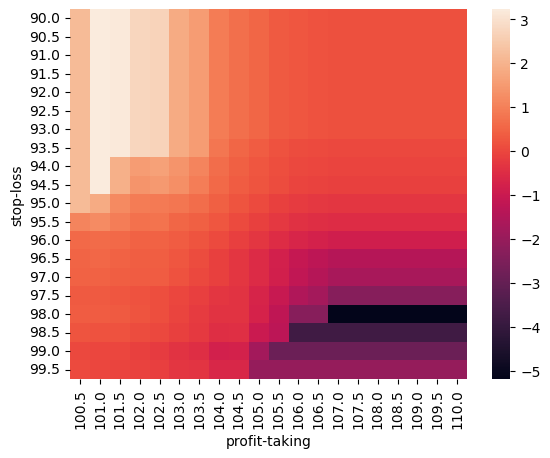

In [19]:
# Example of data analysis that can be compared to Lopez's figures.

i=1
print('Figure 13.'+str(number[i-1]))
sns.heatmap(sharpe_ratio_matrices[i-1])
plt.yticks(rotation='horizontal')
plt.show()

In [20]:
# The function also returns the exit position of each pair of bars and scenario.

experiments[0]['simulates']

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,97.821342,97.821342,97.821342,97.821342,97.821342,97.821342,97.821342,97.821342,97.821342,97.821342,...,98.999042,98.999042,98.999042,98.999042,98.999042,102.505622,102.505622,101.982091,101.982091,100.527322
1,99.517391,99.517391,99.517391,99.517391,99.517391,99.517391,99.517391,99.517391,99.517391,99.517391,...,98.899372,98.899372,98.899372,98.899372,98.899372,98.899372,98.899372,98.899372,98.899372,98.899372
2,100.854187,100.854187,100.854187,100.854187,100.854187,100.854187,100.854187,100.854187,100.854187,100.854187,...,98.661477,98.661477,98.661477,98.661477,98.661477,98.661477,98.661477,98.661477,101.053802,101.053802
3,99.586678,99.586678,99.586678,99.586678,99.586678,99.586678,99.586678,99.586678,99.586678,99.586678,...,98.761163,98.761163,98.761163,103.601944,103.601944,102.637946,102.095727,102.095727,101.363964,101.363964
4,99.697047,99.697047,99.697047,99.697047,99.697047,99.697047,99.697047,99.697047,99.697047,99.697047,...,99.474602,99.474602,99.474602,99.474602,99.474602,99.474602,99.474602,99.474602,99.474602,100.622850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,99.609225,99.609225,99.609225,99.609225,99.609225,99.609225,99.609225,99.609225,99.609225,99.609225,...,99.027172,99.027172,99.027172,99.027172,99.027172,99.027172,99.027172,99.027172,99.027172,99.027172
96,100.124133,100.124133,100.124133,100.124133,100.124133,100.124133,100.124133,100.124133,100.124133,100.124133,...,98.647439,98.647439,98.647439,98.647439,98.647439,102.500261,102.500261,101.738933,101.738933,100.614961
97,98.710824,98.710824,98.710824,98.710824,98.710824,98.710824,98.710824,98.710824,98.710824,98.710824,...,98.716637,98.716637,98.716637,98.716637,98.716637,98.716637,98.716637,98.716637,98.716637,98.716637
98,98.747932,98.747932,98.747932,98.747932,98.747932,98.747932,98.747932,98.747932,98.747932,98.747932,...,99.320886,104.543192,104.466778,103.506688,103.506688,102.808419,102.808419,101.758734,101.758734,100.946618


# Example with real data
---


In what follows we will give an example of usage of `optimal_trading_rule`.\
The data will be the last 200 `CLOSE` values of `USDEUR`

In [17]:
# ['VOLUME','OPEN', 'CLOSE', 'LOW', 'TRANSACTIONS']

# Defining time_index_col (must be the same column in all inputs) and keep_cols refering to the columns that will remain in the dataset
dataloader = DataLoader(time_index_col= 'DATE', 
                keep_cols = ['CLOSE'])

In [18]:
# loading assets into to an unique df
data = dataloader.load_dataset({'USDEUR':'../data/FX/USDEUR_2020-04-07_2022-04-06.parquet'}).iloc[:200]

In [19]:
# We split the set into two: historical and future prices.

historical_prices = data.loc[data.index[:100]]

future_prices = data.loc[data.index[100:]]

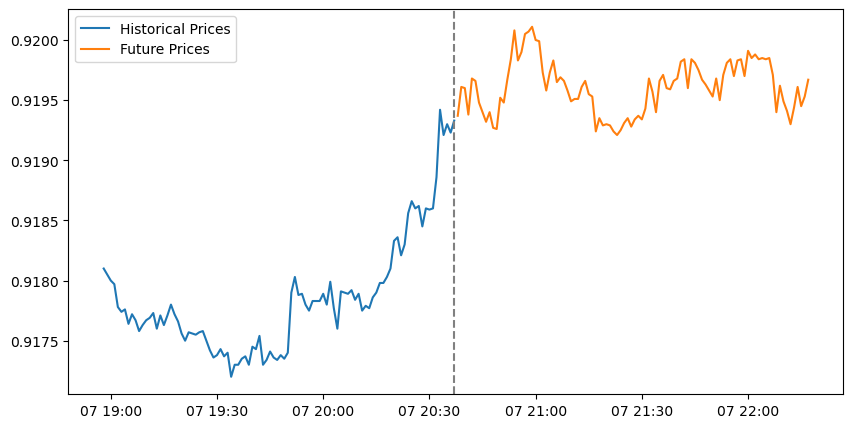

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(historical_prices, label = 'Historical Prices')
ax.plot(future_prices, label = 'Future Prices') # This is impossible in real world.

ax.axvline(historical_prices.index[-1], color='gray', ls='--')
plt.legend()
plt.show()

In [21]:
forecast = future_prices.iloc[-1]['USDEUR_CLOSE'] # Fixed a forecast, in this way is impossible in real world.
position = historical_prices.shape[0] - 30 # Fixed a position

In [22]:
historical_prices = historical_prices['USDEUR_CLOSE'] # Must be a Series.

In [23]:
sb.optimal_trading_rule(
    historical_prices=historical_prices,
    forecast=forecast,
    position=position,
    NUM_SCENARIOS=100,
    TO_PRINT=False
)

,stop-loss,profit-taking,sharpe_ratio
17,0.917796,0.91956,2.303889
